In [32]:
import gymnasium as gym
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from helper_functions import reward_print
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
device = "cpu"
print(device)
CUDA_LAUNCH_BLOCKING=1

cpu


In [44]:
# AC2 algorithm 
class A2C:
    def __init__(self, env):
        self.actor = Actor(env)
        self.critic = Critic(self.actor.env.observation_space.shape[0])
    
    # Main training loop
    def train(self, episodes, gamma, greedy=False):
        total_reward = [0] * episodes
        for i in range(episodes):
            step = rewards = 0
            done = False     
            state, info = self.actor.env.reset()
            state = torch.tensor(state)
            action_list = []
            while not done:
                # Actor makes decision 
                # Environment returns state and reward
                next_state, reward, done, action = self.actor.act(state, greedy)
                next_state = torch.tensor(next_state)#.todevice
                # Critic evaluates action 
                adv = self.critic.evaluate(state, next_state, reward, gamma)
                # Pass that value to the Actor
                self.actor.evaluation(action, adv, state)
                #action_list += action
                state = next_state
                step += 1
                rewards += reward
                
                # Before it is done
                if done:
                    reward = -300
                    next_state = None
                    adv = self.critic.evaluate(state, next_state, reward, gamma ** step)
                    self.actor.evaluation(action, adv, state)
                
            total_reward[i] = rewards
            print("Episode:", i, " Reward", rewards)
            #print(action_list)
        self.actor.env.close()
        return total_reward

               
    def save(self, filename):
        with open("pickles/" + filename + "actor.pickle", 'wb') as file:
            pickle.dump(self.actor.policy_net1.state_dict(), file)
            
        with open("pickles/" + filename + "actor.pickle", 'wb') as file:
            pickle.dump(self.actor.policy_net2.state_dict(), file)
            
        with open("pickles/" + filename + "actor.pickle", 'wb') as file:
            pickle.dump(self.actor.policy_net3.state_dict(), file)
            
        with open("pickles/" + filename + "actor.pickle", 'wb') as file:
            pickle.dump(self.actor.policy_net4.state_dict(), file)
            
        with open("pickles/" + filename + "critic.pickle", 'wb') as file:
            pickle.dump(self.critic.policy_net.state_dict(), file)

        

In [34]:
# Actor thread
class ActorNet(nn.Module):  
    def __init__(self, obs, act):
        super(ActorNet, self).__init__()
        self.layer1 = nn.Linear(obs, 256)
        self.layer2 = nn.Linear(256, 200)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.softmax(self.layer2(x), dim=-1)
        return x
        

class Actor:
    def __init__(self, env):
        self.env_type = env
        self.env = gym.make(env)
        self.policy_net1 = ActorNet(self.env.observation_space.shape[0], self.env.action_space.shape[0])
        self.optimizer1 = optim.AdamW(self.policy_net1.parameters(), amsgrad=True, lr=.001)
        self.policy_net2 = ActorNet(self.env.observation_space.shape[0], self.env.action_space.shape[0])
        self.optimizer2 = optim.AdamW(self.policy_net2.parameters(), amsgrad=True, lr=.001)
        self.policy_net3 = ActorNet(self.env.observation_space.shape[0], self.env.action_space.shape[0])
        self.optimizer3 = optim.AdamW(self.policy_net3.parameters(), amsgrad=True, lr=.001)
        self.policy_net4 = ActorNet(self.env.observation_space.shape[0], self.env.action_space.shape[0])
        self.optimizer4 = optim.AdamW(self.policy_net4.parameters(), amsgrad=True, lr=.001)
    
    def act(self, state, greedy):
        # Get the weights from the policy net
        weights1 = self.policy_net1(state)
        weights2 = self.policy_net2(state)
        weights3 = self.policy_net3(state)
        weights4 = self.policy_net4(state)
        # if greedy get max-arg 
        if greedy: 
            action1 = torch.argmax(weights1)
            action2 = torch.argmax(weights2)
            action3 = torch.argmax(weights3)
            action4 = torch.argmax(weights4)
        # Use multinomial to select probability / action
        else:
            action1 = torch.multinomial(weights1, 1)
            action2 = torch.multinomial(weights2, 1)
            action3 = torch.multinomial(weights3, 1)
            action4 = torch.multinomial(weights4, 1)
        # Run and return the action 
        actions = torch.tensor([action1.item(), action2.item(), action3.item(), action4.item()])
        actions = (actions / 100) - 1
       # print(actions)
        state, reward, terminated, truncated, _ = self.env.step(actions)
        return state, reward, terminated or truncated, actions

    
    def evaluation(self, action, advantage, state):
        # Get the weights from the policy 
        weights1 = self.policy_net1(state)
        weights2 = self.policy_net2(state)
        weights3 = self.policy_net3(state)
        weights4 = self.policy_net4(state)
        # Calculate the log probability with the weights of the 
        # current state and action and then use the adv to get the loss 
        action = (action + 1) * 100
        prob1 = torch.distributions.Categorical(weights1).log_prob(torch.tensor(action[0], dtype=torch.int))  
        loss1 = -1 * prob1 * advantage.detach()
        # back prop
        self.optimizer1.zero_grad()
        loss1.backward()
        self.optimizer1.step()
        
        prob2 = torch.distributions.Categorical(weights2).log_prob(torch.tensor(action[1], dtype=torch.int))  
        loss2 = -1 * prob2 * advantage.detach()
        # Backpropagation
        self.optimizer2.zero_grad()
        loss2.backward()
        self.optimizer2.step()

        prob3 = torch.distributions.Categorical(weights3).log_prob(torch.tensor(action[2], dtype=torch.int))  
        loss3 = -1 * prob3 * advantage.detach()
        # Backpropagation
        self.optimizer3.zero_grad()
        loss3.backward()
        self.optimizer3.step()
        
        prob4 = torch.distributions.Categorical(weights4).log_prob(torch.tensor(action[3], dtype=torch.int))  
        loss4 = -1 * prob4 * advantage.detach()
        # Backpropagation
        self.optimizer4.zero_grad()
        loss4.backward()
        self.optimizer4.step()
    
    def change_render(self, render):
        if render:
            self.env = gym.make(self.env_type, render_mode="human", max_episode_steps=200)
        else: 
            self.env = gym.make(self.env_type, max_episode_steps=200)

In [35]:
# Critic thread
class CriticNet(nn.Module):  
    def __init__(self, obs):
        super(CriticNet, self).__init__()
        self.layer1 = nn.Linear(obs, 128)
        self.layer2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        return  self.layer2(x)


class Critic:
    def __init__(self, obs):
        
        self.policy_net = CriticNet(obs)
        self.optimizer = optim.AdamW(self.policy_net.parameters(),amsgrad=True, lr=.001)
    
    
    def evaluate(self, state, next_state, reward, gamma):
        # Get Qvalue and next Qvalue from policy         
        Qvalue = self.policy_net(state)
        if next_state is not None:
            next_Qvalue = self.policy_net(next_state)
        else: 
            next_Qvalue = 0
        
        # Calculate the TD and advantage for the next action
        TD = reward + (gamma * next_Qvalue)
        adv = TD - Qvalue
        TD = torch.tensor([TD])
        loss_function = nn.MSELoss()
        loss = loss_function(Qvalue, TD)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return adv

C:\Users\Dan\AppData\Local\Temp\ipykernel_66864\228400539.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob1 = torch.distributions.Categorical(weights1).log_prob(torch.tensor(action[0], dtype=torch.int))
C:\Users\Dan\AppData\Local\Temp\ipykernel_66864\228400539.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob2 = torch.distributions.Categorical(weights2).log_prob(torch.tensor(action[1], dtype=torch.int))
C:\Users\Dan\AppData\Local\Temp\ipykernel_66864\228400539.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob3 = t

Episode: 0  Reward tensor(-9.4904, dtype=torch.float64)
Episode: 1  Reward tensor(-109.9906, dtype=torch.float64)
Episode: 2  Reward tensor(-11.1684, dtype=torch.float64)
Episode: 3  Reward tensor(-9.7021, dtype=torch.float64)
Episode: 4  Reward tensor(-3.9311, dtype=torch.float64)
Episode: 5  Reward tensor(-132.4801, dtype=torch.float64)
Episode: 6  Reward tensor(-9.4413, dtype=torch.float64)
Episode: 7  Reward tensor(-4.3152, dtype=torch.float64)
Episode: 8  Reward tensor(-6.7140, dtype=torch.float64)
Episode: 9  Reward tensor(-9.0716, dtype=torch.float64)
Episode: 10  Reward tensor(-4.1966, dtype=torch.float64)
Episode: 11  Reward tensor(-9.2911, dtype=torch.float64)
Episode: 12  Reward tensor(-9.7693, dtype=torch.float64)
Episode: 13  Reward tensor(-9.9988, dtype=torch.float64)
Episode: 14  Reward tensor(-10.6084, dtype=torch.float64)
Episode: 15  Reward tensor(-11.6043, dtype=torch.float64)
Episode: 16  Reward tensor(-13.7003, dtype=torch.float64)
Episode: 17  Reward tensor(-17.85

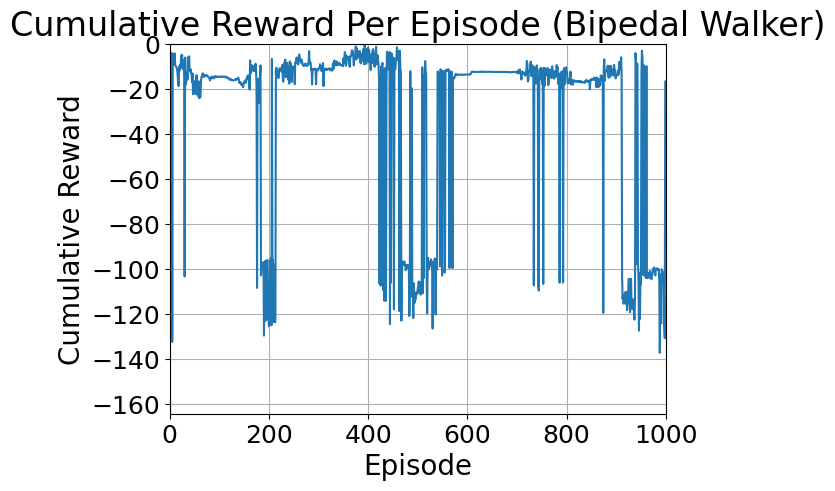

Episode: 0  Reward tensor(-13.6600, dtype=torch.float64)
Episode: 1  Reward tensor(-13.6156, dtype=torch.float64)
Episode: 2  Reward tensor(-13.3703, dtype=torch.float64)
Episode: 3  Reward tensor(-13.9282, dtype=torch.float64)
Episode: 4  Reward tensor(-13.9276, dtype=torch.float64)
Episode: 5  Reward tensor(-13.5266, dtype=torch.float64)
Episode: 6  Reward tensor(-13.9678, dtype=torch.float64)
Episode: 7  Reward tensor(-13.7766, dtype=torch.float64)
Episode: 8  Reward tensor(-12.3448, dtype=torch.float64)
Episode: 9  Reward tensor(-14.1975, dtype=torch.float64)
Episode: 10  Reward tensor(-13.7690, dtype=torch.float64)


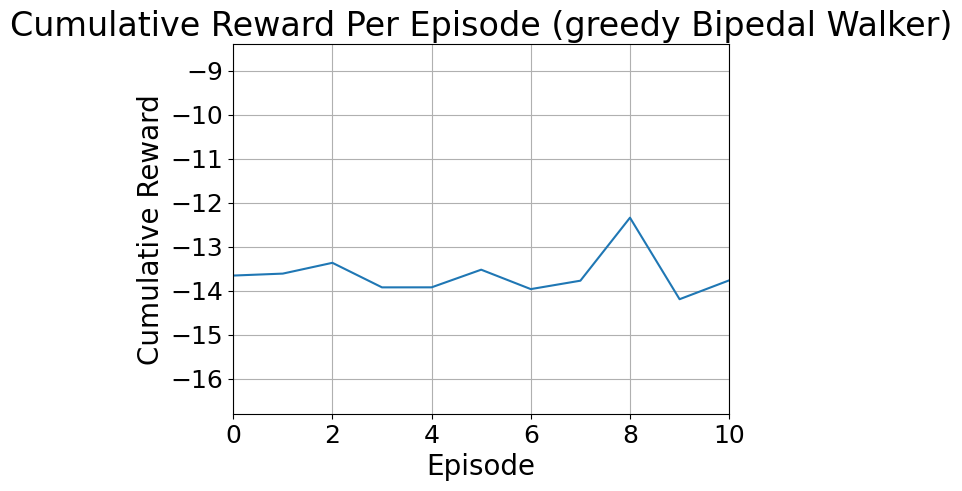

In [42]:
# AC2 Agent for Cart Pole
environment = 'BipedalWalker-v3'
agent = A2C(environment)

episodes = 1000
gamma = .99

agent.actor.change_render(False)
# Main training session
total_rewards = agent.train(episodes, gamma)
print("Best reward: ", max(total_rewards))
reward_print(total_rewards, episodes, "Bipedal Walker")

# Greedy run 
agent.actor.change_render(False)
total_greedy_rewards = agent.train(11, gamma, greedy=True)
reward_print(total_greedy_rewards, 10, "greedy Bipedal Walker")

Average tensor(-31.0077, dtype=torch.float64)


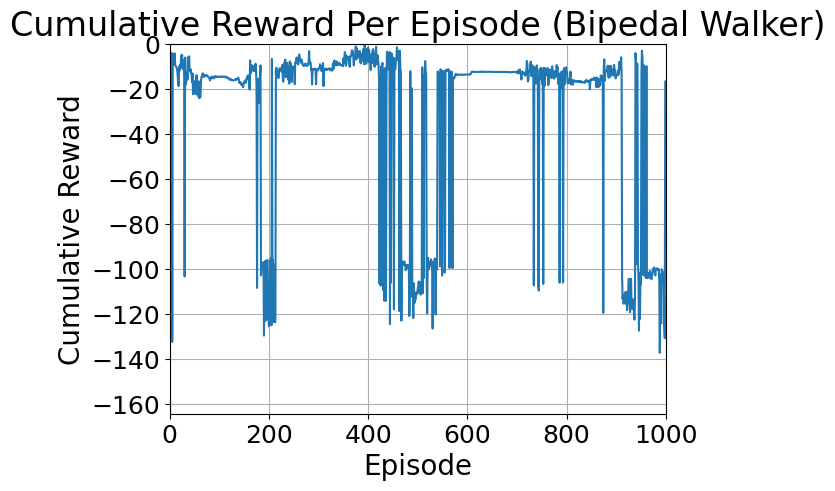

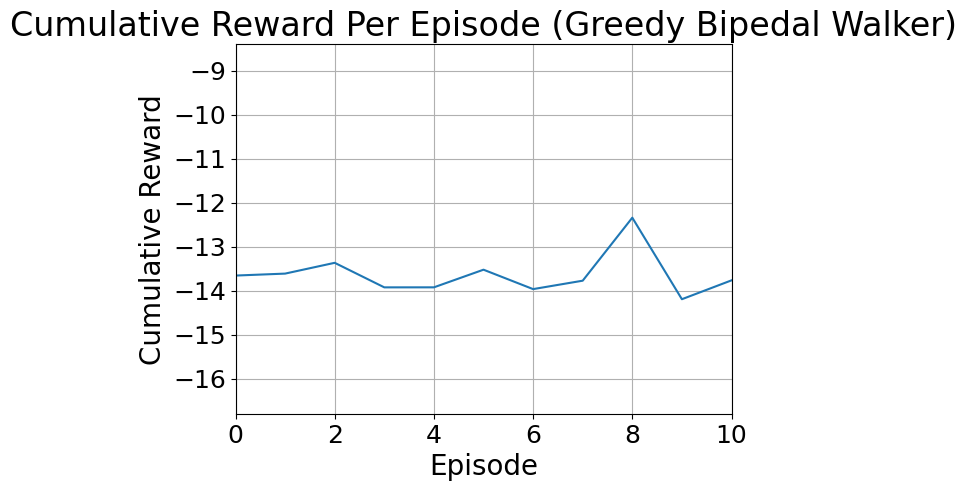

In [43]:
# Prints the final graph and saves final weights

print("Average", sum(total_rewards)/ len(total_rewards))
reward_print(total_rewards, episodes, "Bipedal Walker")
reward_print(total_greedy_rewards, 10, "Greedy Bipedal Walker")
agent.save("drpreisl_BipedalWalker")

In [47]:
# I realized that I didnt change the filenames in the save function so this is a hotfix
filename = "drpreisl_Walker_"
with open("pickles/" + filename + "actor1.pickle", 'wb') as file:
    pickle.dump(agent.actor.policy_net1.state_dict(), file)
            
with open("pickles/" + filename + "actor2.pickle", 'wb') as file:
    pickle.dump(agent.actor.policy_net2.state_dict(), file)
            
with open("pickles/" + filename + "actor3.pickle", 'wb') as file:
    pickle.dump(agent.actor.policy_net3.state_dict(), file)
            
with open("pickles/" + filename + "actor4.pickle", 'wb') as file:
    pickle.dump(agent.actor.policy_net4.state_dict(), file)
            
with open("pickles/" + filename + "critic.pickle", 'wb') as file:
    pickle.dump(agent.critic.policy_net.state_dict(), file)